In [1]:
import sys
import numpy as np
from datetime import datetime
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model

In [2]:
sys.path.append('../')
from siamese_networks.siamese_network import build_siamese_model
from siamese_networks.build_siamese_pairs import make_pairs
from siamese_networks import utils

In [3]:
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# add a channel dimension to the images
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")

(x_pair_train, y_label_train) = make_pairs(x_train, y_train)
(x_pair_test, y_label_test) = make_pairs(x_test, y_test)

[INFO] loading MNIST dataset...
[INFO] preparing positive and negative pairs...


## Configuration

In [4]:
output_folder = 'output-' + datetime.now().strftime("%Y%m%d-%H%M%S")
cfg = {
    'IMG_SHAPE' : (28, 28, 1),
    'BATCH_SIZE': 64,
    'EPOCHS': 10,
    'DROPOUT_RATE': 0.3,
    'OUTPUT_FOLDER': output_folder
}

In [5]:
print(cfg)

{'IMG_SHAPE': (28, 28, 1), 'BATCH_SIZE': 64, 'EPOCHS': 10, 'DROPOUT_RATE': 0.3, 'OUTPUT_FOLDER': 'output-20201219-154411'}


In [6]:
# configure the siamese network

print("[INFO] building siamese network...")
img_a = Input(shape=cfg['IMG_SHAPE'])
img_b = Input(shape=cfg['IMG_SHAPE'])

featureExtractor = build_siamese_model(cfg['IMG_SHAPE'], dropout_rate=cfg['DROPOUT_RATE'])

featureExtractor.summary()

[INFO] building siamese network...
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)

In [7]:
feats_a = featureExtractor(img_a)
feats_b = featureExtractor(img_b)

# finally, construct the siamese network
distance = Lambda(utils.euclidean_distance)([feats_a, feats_b])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[img_a, img_b], outputs=outputs)

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 48)           19888       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           functional_1[0][0]    

[INFO] compiling model...
[INFO] training model...
Epoch 1/10
   1/1875 [..............................] - ETA: 0s - loss: 0.6928 - accuracy: 0.4844WARNING:tensorflow:From /home/ricky/Envs/tf-2.3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1875/1875 [==============================] - 272s 145ms/step - loss: 0.6312 - accuracy: 0.6300 - val_loss: 0.5934 - val_accuracy: 0.6798
Epoch 2/10
1875/1875 [==============================] - 266s 142ms/step - loss: 0.5919 - accuracy: 0.6839 - val_loss: 0.5463 - val_accuracy: 0.7359
Epoch 3/10
1875/1875 [==============================] - 260s 138ms/step - loss: 0.5501 - accuracy: 0.7225 - val_loss: 0.5053 - val_accuracy: 0.7637
Epoch 4/10
1875/1875 [==============================] - 248s 132ms/step - loss: 0.5181 - accuracy: 0.7457 - val_loss: 0.4659 - v

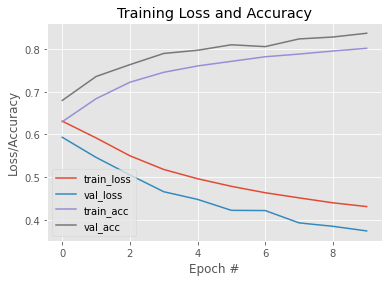

In [8]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


logdir = os.path.join(cfg['OUTPUT_FOLDER'], 'logs')
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

# train the model
print("[INFO] training model...")
history = model.fit([x_pair_train[:, 0], x_pair_train[:, 1]],
                    y_label_train[:],
                    validation_data=(
                        [x_pair_test[:, 0], x_pair_test[:, 1]],
                        y_label_test[:]
                    ),
                    batch_size=cfg['BATCH_SIZE'], 
                    epochs=cfg['EPOCHS'],
                    callbacks=[tensorboard_callback])

MODEL_PATH = os.path.join(cfg['OUTPUT_FOLDER'], 'siamese_model')

# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)

PLOT_PATH = os.path.join(cfg['OUTPUT_FOLDER'], 'plot.png')

# plot the training history
print("[INFO] plotting training history...")
utils.plot_training(history, PLOT_PATH)